In [1]:
# https://towardsdatascience.com/deep-learning-vs-puzzle-games-e996feb76162abs
# https://github.com/kgaspard/flow-free-ai

In [2]:
# solution visualizer

In [3]:
# solution sanity checker

In [4]:
import os
import sys
import git
import pathlib

In [5]:
PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)
print(PROJ_ROOT)  

/repos/pathfinder


In [6]:
import re
import numpy as np
import matplotlib.colors as cm
import matplotlib.pyplot as plt

In [7]:
data_folder = pathlib.Path(PROJ_ROOT, "data")
data_folder

PosixPath('/repos/pathfinder/data')

In [8]:
filename = "five.txt"
file = pathlib.Path(data_folder, filename)

In [9]:
# removing the new line characters
with open(file) as f:
    lines = [line.rstrip() for line in f]

In [10]:
set0 = lines[0]

In [11]:
size = set0.split(';')[0]
print(size)

5


In [12]:
set0

'5;1:1;5:4;3:3;1:2;2:4;3:2;4:2;5:5=1:1;2:1;3:1;4:1;5:1;5:2;5:3;5:4|3:3;3:4;3:5;2:5;1:5;1:4;1:3;1:2|2:4;2:3;2:2;3:2|4:2;4:3;4:4;4:5;5:5'

In [13]:
problem_, solution = set0.split("=")
# Find the index of the first semicolon to ignore the first entry which gives the size of the problem
semicolon_index = problem_.find(';')
# Extract the substring after the first semicolon
problem = problem_[semicolon_index + 1:]

In [14]:
problem

'1:1;5:4;3:3;1:2;2:4;3:2;4:2;5:5'

In [15]:
solution

'1:1;2:1;3:1;4:1;5:1;5:2;5:3;5:4|3:3;3:4;3:5;2:5;1:5;1:4;1:3;1:2|2:4;2:3;2:2;3:2|4:2;4:3;4:4;4:5;5:5'

In [16]:
# Split the string using ';' delimiter
elements = problem.split(';')
# Group the elements in pairs
subproblem_keys = [f'{elements[i]};{elements[i+1]}' for i in range(0, len(elements)-1, 2)]

In [17]:
subproblem_keys

['1:1;5:4', '3:3;1:2', '2:4;3:2', '4:2;5:5']

In [18]:
subsolutions_entries = solution.split("|") 

In [19]:
set0_dict = dict(zip(subproblem_keys, subsolutions_entries))

In [20]:
def has_duplicate_coordinates(dictionary):
    """Check if there is any overlap between solutions, 
    i.e., no coordinate appears twice in solutions"""
    seen_coordinates = set()

    for value in dictionary.values():
        coordinates = value.split(';')
        for coordinate in coordinates:
            if coordinate in seen_coordinates:
                return True
            seen_coordinates.add(coordinate)

    return False

In [21]:
def check_match(dictionary):
    """Check if the start and end points of the problem matches with the solution"""
    for key, value in dictionary.items():
        key_parts = key.split(';')
        value_parts = value.split(';')
        # Check if the first and last parts match between key and entry
        if key_parts[0] != value_parts[0] or key_parts[-1] != value_parts[-1]:
            return False
    return True

In [22]:
set0_dict

{'1:1;5:4': '1:1;2:1;3:1;4:1;5:1;5:2;5:3;5:4',
 '3:3;1:2': '3:3;3:4;3:5;2:5;1:5;1:4;1:3;1:2',
 '2:4;3:2': '2:4;2:3;2:2;3:2',
 '4:2;5:5': '4:2;4:3;4:4;4:5;5:5'}

In [23]:
def get_problem_size(dictionary):
    """Find the N for a NxN problem"""
    # Extract integers from dictionary values and find the largest integer
    all_integers = set([int(num) for value in dictionary.values() for num in re.split(';|:', value)])
    largest_integer = max(all_integers)
    return largest_integer
    

In [24]:
# Visualize the problem-solution set
def visualize_freeflow(dictionary):

    # Get the size of the problem
    size = get_problem_size(dictionary)

    # Define colors
    colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)]
    # colors = ['r', 'k', 'y', 'g', 'b', 'm', 'c',]
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.set_xticks(range(1,size+1,1),range(1,size+1,1))
    ax.set_yticks(range(1,size+1,1),range(1,size+1,1))
    
    # print start-end points
    for i,endpointpairs in enumerate(dictionary.keys()):
        endpoint_coordinates = endpointpairs.split(';')
        x_coordinates, y_coordinates = zip(*(map(int, coord.split(':')) for coord in endpoint_coordinates))
        
        # Plot the start point
        ax.plot(x_coordinates[0], y_coordinates[0], marker='o', markersize=10, color = colors[i % len(colors)])
        # Plot the end point
        ax.plot(x_coordinates[-1], y_coordinates[-1], marker='s',  markersize=10, color = colors[i % len(colors)])
    
    # print paths
    for i, solution_path in enumerate(dictionary.values()):
        path_coordinates = solution_path.split(';')
        
        # Extract x and y coordinates from the string
        x_coordinates, y_coordinates = zip(*(map(int, coord.split(':')) for coord in path_coordinates))
        
        # Plot the line
        ax.plot(x_coordinates, y_coordinates, linestyle='-', linewidth=5, color = colors[i % len(colors)])
        
       
    # Display the plot
    ax.set_aspect('equal', adjustable='datalim')
    plt.grid(visible=True)
    plt.show()


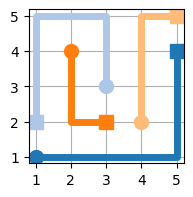

In [25]:
visualize_freeflow(set0_dict)

In [26]:
def flip_about_origin(point, orientation):
    x, y = point
    if orientation == 'h':
        y_flipped = - y
        x_flipped = x
    elif orientation == 'v':
        y_flipped = y
        x_flipped = -x
    else:
        print("Wrong orientation. Valid types are 'h' or 'v'")

    return x_flipped, y_flipped
    
def rotate_point_about_origin(point, angle):
    x, y = point
    x_rotated = x * np.cos(angle) - y * np.sin(angle)
    y_rotated = x * np.sin(angle) + y * np.cos(angle)
    return x_rotated, y_rotated

def translate_to_origin(size, point):
    x, y = point
    return (x-(size+1)/2, y-(size+1)/2)

def translate_back(size, point):
    x, y = point
    return (int(round((x+(size+1)/2))), int(round(y+(size+1)/2)))

In [27]:
def flip_soln(dictionary, orientation):
    # check if the key entries match with the first and last entries of value esubsolutions_entries
    check_match(dictionary)

    # Get the size of the problem
    size = get_problem_size(dictionary)

    # keys and values for new dictonary
    keys = []
    values = []
    
    # Transform all coordinates
    for i, solution_path in enumerate(dictionary.values()):
        new_path_points = []
        for path_coord in solution_path.split(';'):
            point = list(map(int, path_coord.split(':')))
            temp_point = translate_to_origin(size, point)
            temp_point = flip_about_origin(temp_point, orientation)
            temp_point = translate_back(size, temp_point)
            new_path_points.append(temp_point)

        # Convert the path point coordinates to the dictionary value entry format
        value_entry = ';'.join(f'{x}:{y}' for x, y in new_path_points)
        values.append(value_entry)
            
        # Convert the path point coordinates to the dictionary key entry format
        endpoints = [new_path_points[0], new_path_points[-1]]
        key_entry = ';'.join(f'{x}:{y}' for x, y in endpoints)
        keys.append(key_entry)
   
    return dict(zip(keys,values))

In [28]:
def rotate_soln(dictionary, angle_in_degrees):
    # check if the key entries match with the first and last entries of value esubsolutions_entries
    check_match(dictionary)

    # Get the size of the problem
    size = get_problem_size(dictionary)

    # keys and values for new dictonary
    keys = []
    values = []
    
    # Transform all coordinates
    for i, solution_path in enumerate(dictionary.values()):
        new_path_points = []
        for path_coord in solution_path.split(';'):
            point = list(map(int, path_coord.split(':')))
            temp_point = translate_to_origin(size, point)
            temp_point = rotate_point_about_origin(temp_point, np.radians(angle_in_degrees))
            temp_point = translate_back(size, temp_point)
            new_path_points.append(temp_point)

        # Convert the path point coordinates to the dictionary value entry format
        value_entry = ';'.join(f'{x}:{y}' for x, y in new_path_points)
        values.append(value_entry)
            
        # Convert the path point coordinates to the dictionary key entry format
        endpoints = [new_path_points[0], new_path_points[-1]]
        key_entry = ';'.join(f'{x}:{y}' for x, y in endpoints)
        keys.append(key_entry)
   
    return dict(zip(keys,values))

In [29]:
import itertools
def shuffle_order(dictionary):
    """Shuffles the key-value ordering of the dictionary."""
    # create a list of (key,value) entries
    dict_items = list(dictionary.items())
    # create a list of all permutations from the list of (key,value)
    all_perms = list(itertools.permutations(dict_items))
    # convert the list into dictionary
    all_shuffled_dicts = [dict(shuffled_list) for shuffled_list in all_perms]
    # return the dictionary
    return all_shuffled_dicts   

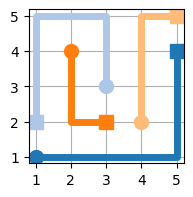

In [30]:
visualize_freeflow(set0_dict)

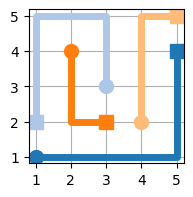

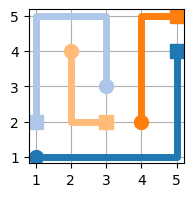

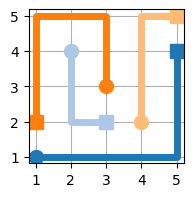

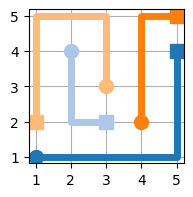

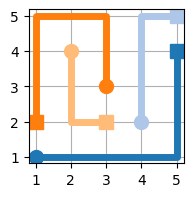

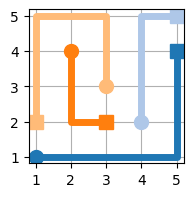

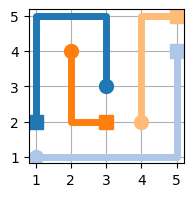

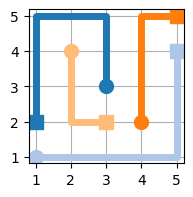

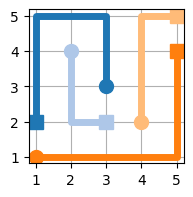

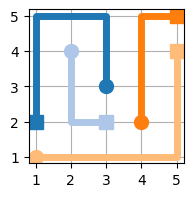

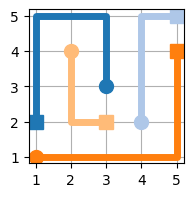

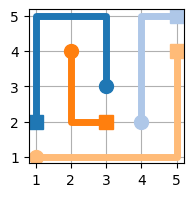

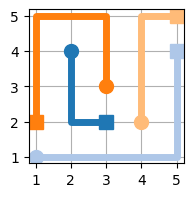

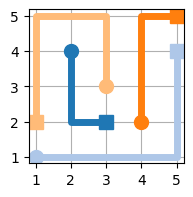

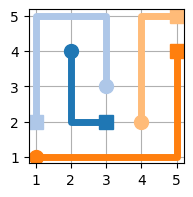

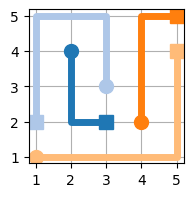

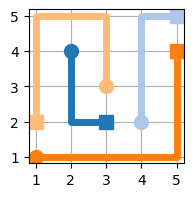

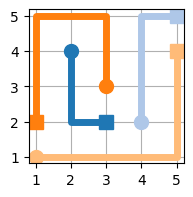

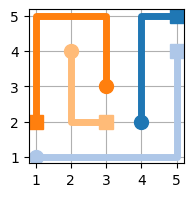

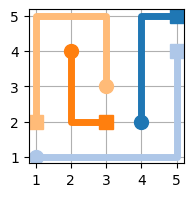

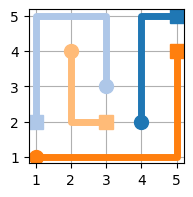

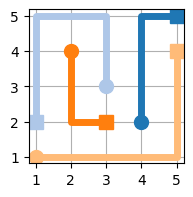

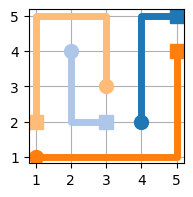

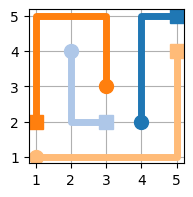

In [31]:
all_permutations = shuffle_order(set0_dict)
for permutation in all_permutations:
    visualize_freeflow(permutation)

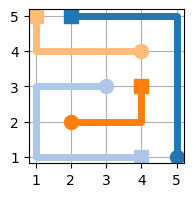

In [33]:
rot_set = rotate_soln(set0_dict, 90)
visualize_freeflow(rot_set)

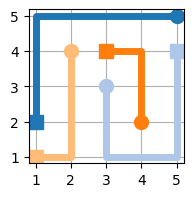

In [34]:
rot2_set = rotate_soln(set0_dict, 90*2)
visualize_freeflow(rot2_set)

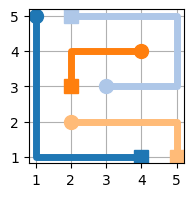

In [35]:
rot3_set = rotate_soln(set0_dict, 90*3)
visualize_freeflow(rot3_set)

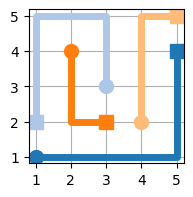

In [36]:
rot4_set = rotate_soln(set0_dict, 90*4)
visualize_freeflow(rot4_set)

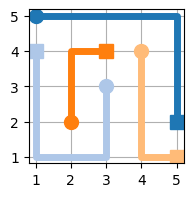

In [37]:
flip_set = flip_soln(set0_dict, 'h')
visualize_freeflow(flip_set)

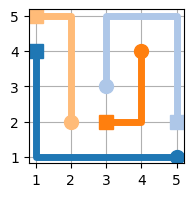

In [38]:
flip_set = flip_soln(set0_dict, 'v')
visualize_freeflow(flip_set)